In [33]:
# MP_work_notebook

In [34]:
from alpaca.data.historical import CryptoHistoricalDataClient

# No keys required for crypto data
client = CryptoHistoricalDataClient()

In [35]:
import alpaca_trade_api as tradeapi
import pandas as pd
import pandas_ta as ta
import numpy as np
# import mplfinance as mpf
import matplotlib.pyplot as plt

#Loading Alpaca API keys
API_Key = "PK688IQ8GKXYNUE4M7YX"
API_secret_key = "LKfuASkhgHQm6xnD6em7CHrZbPoB8Nt7Pabo0jPZ"
API_base_url = "https://paper-api.alpaca.markets"
api = tradeapi.REST(API_Key, API_secret_key, API_base_url, api_version='v2')

In [36]:
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame

# user input for the ticker and date range
crypto_input = input("Enter the cryptocurrency symbols (e.g., BTC, ETH, DOGE, LTC): ")
crypto_list = [f"{ticker.strip()}/USD" for ticker in crypto_input.split(",")]  # Format as f-string

start_year = input("Enter the start year (YYYY): ")
start_month = input("Enter the start month (MM): ")
start_day = input("Enter the start day (DD): ")

end_year = input("Enter the end year (YYYY): ")
end_month = input("Enter the end month (MM): ")
end_day = input("Enter the end day (DD): ")

# Construct start and end date strings
start_date = f"{start_year}-{start_month}-{start_day}"
end_date = f"{end_year}-{end_month}-{end_day}"

# Creating request object
request_params = CryptoBarsRequest(
    symbol_or_symbols=crypto_list,  # Use the formatted list of tickers
    timeframe=TimeFrame.Day,
    start=start_date,
    end=end_date
)

Enter the cryptocurrency symbols (e.g., BTC, ETH, DOGE, LTC):  BTC, ETH, DOGE, LTC
Enter the start year (YYYY):  2023
Enter the start month (MM):  07
Enter the start day (DD):  07
Enter the end year (YYYY):  2024
Enter the end month (MM):  07
Enter the end day (DD):  07


In [37]:
# request_params

In [38]:
# Retrieve daily bars for Bitcoin in a DataFrame and printing it
crypto_bars = client.get_crypto_bars(request_params)
# Convert to dataframe
crypto_df = crypto_bars.df.reset_index()

#Format and clean datafame
crypto_df.loc[:,'date'] = pd.to_datetime(crypto_df.loc[:,'timestamp']).dt.date
clean_crypto_df = crypto_df.copy()[['symbol', 'date', 'open', 'close', 'volume']]
#clean_crypto_df

In [39]:
# Get unique symbols from the DataFrame
unique_symbols = clean_crypto_df['symbol'].unique()

# Create a dictionary to hold separate DataFrames for each unique symbol
clean_crypto_dfs = {}

# Loop through each unique symbol and create a DataFrame for it
for symbol in unique_symbols:
    # Create a valid variable name
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name
    globals()[f"{variable_name}_df"] = clean_crypto_df[crypto_df['symbol'] == symbol].reset_index(drop=True)

    # print(f"\nDataFrame for {variable_name}:\n", globals()[f"{variable_name}_df"])
        
# Now you can access the DataFrames with variable names
# print(BTC_USD_df)  # DataFrame for Bitcoin
# print(ETH_USD_df)  # DataFrame for Ethereum, if it exists

In [40]:
# Create ???_df_calc for each df
for symbol in unique_symbols:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name
    crypto_df_calc = globals()[f"{variable_name}_df"]
    locals()[f"crypto_df_{variable_name}"] = crypto_df_calc
    
#    print(f"\nDataFrame for {variable_name}:\n", locals()[f"crypto_df_{variable_name}"])

In [41]:
# Create ???_df_calc for each df
for symbol in unique_symbols:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name
    crypto_df_calc = globals()[f"{variable_name}_df"]

    #Run calculations
    crypto_first_open = crypto_df_calc['open'].iloc[0]
    crypto_close = crypto_df_calc['close']
    crypto_open = crypto_df_calc['open']
    price_change = ((crypto_close - crypto_first_open) / crypto_first_open) * 100
    prev_close = crypto_df_calc['close'].shift(1)
    daily_change = ((crypto_close - prev_close) / prev_close) * 100
    weights = crypto_df_calc['close']
    volume = crypto_df_calc['volume']
    average_volume_crypto = (volume * weights).sum() / weights.sum()
    volume_change = (((volume - average_volume_crypto) / average_volume_crypto) * 100)
    
    # to decrease the volume change range to manageable levels
    sqrt_volume_change = np.sqrt(np.abs(volume_change))

    # to retain the sign of the original volume change (positive or negative), you can reapply the sign
    sqrt_volume_change = np.sign(volume_change) * sqrt_volume_change

    # Use .loc[] to assign the new calculated columns
    crypto_df_calc.loc[:,'price change %'] = price_change
    crypto_df_calc.loc[:,'daily change %'] =  daily_change
    crypto_df_calc.loc[:,'vol_vs_average %'] = sqrt_volume_change
    

    
    #crypto_first_open = crypto_df_calc['open'].iloc[0]
    #price_change = ((crypto_df_calc.loc[:,'close'] - crypto_first_open) / crypto_first_open) * 100
    #daily_change = ((crypto_df_calc.loc[:,'close'] - crypto_df_calc.loc[:,'open']) / crypto_df_calc.loc[:,'open']) * 100
    #average_volume_crypto = crypto_df_calc['volume'].mean()

    #crypto_df_calc.loc[:, 'price change %'] = ((crypto_df_calc.loc[:,'close'] - crypto_first_open) / crypto_first_open) * 100
    #crypto_df_calc.loc[:, 'daily change %'] = ((crypto_df_calc.loc[:,'close'] - crypto_df_calc.loc[:,'open']) / crypto_df_calc.loc[:,'open']) * 100
    #crypto_df_calc.loc[:, 'vol_vs_average %'] = ((crypto_df_calc.loc[:,'volume'] - average_volume_crypto) / average_volume_crypto) * 100
    
    locals()[f"crypto_df_{variable_name}"] = crypto_df_calc
    
#   print(f"\nDataFrame for {variable_name}:\n", locals()[f"crypto_df_{variable_name}"])

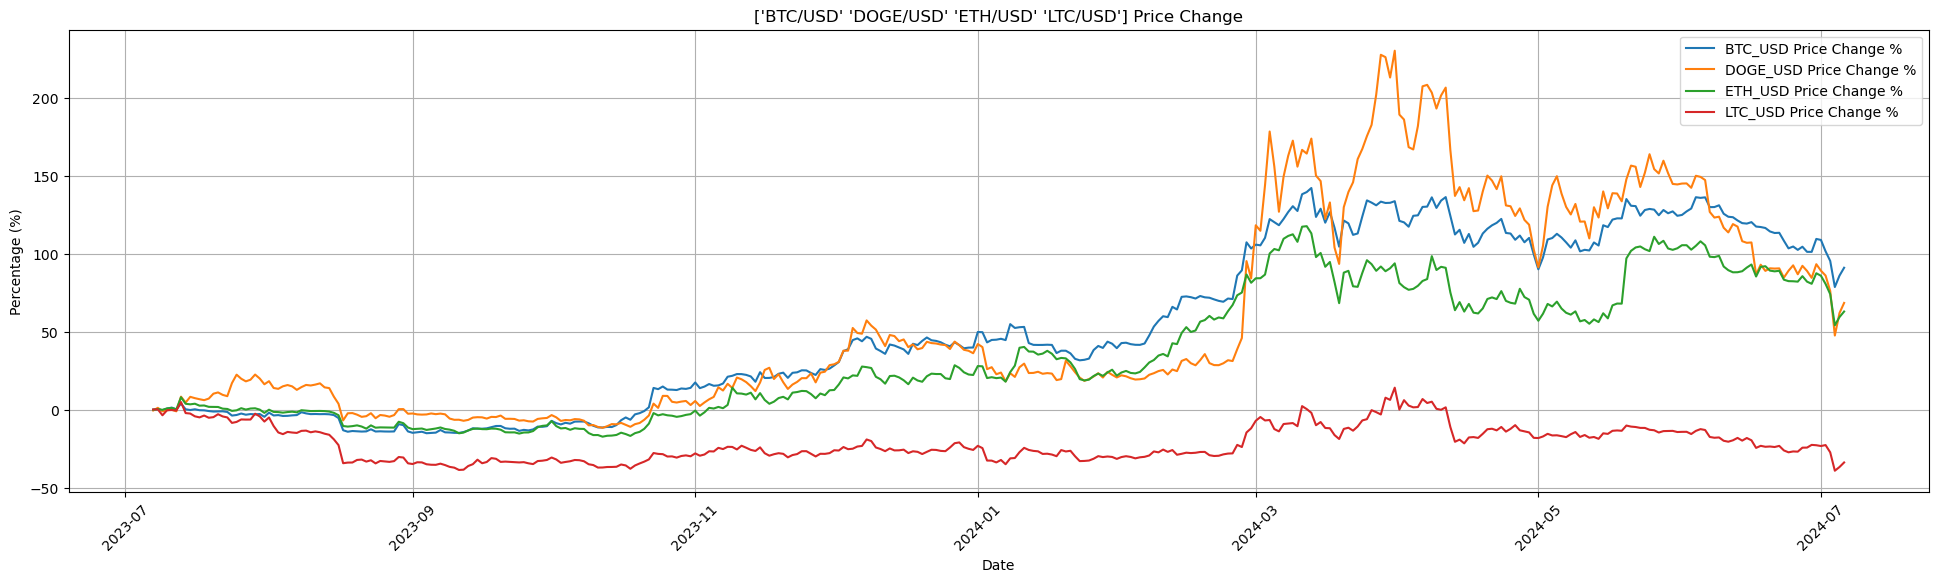

In [42]:
# Create a figure and axis for plotting
plt.figure(figsize=(24, 6))

for symbol in unique_symbols:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name

    plt.plot(locals()[f"crypto_df_{variable_name}"]['date'], 
             locals()[f"crypto_df_{variable_name}"]['price change %'], 
             label=f'{variable_name} Price Change %')
   
# Adding titles and labels
plt.title(f'{unique_symbols} Price Change')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid()  # Show grid

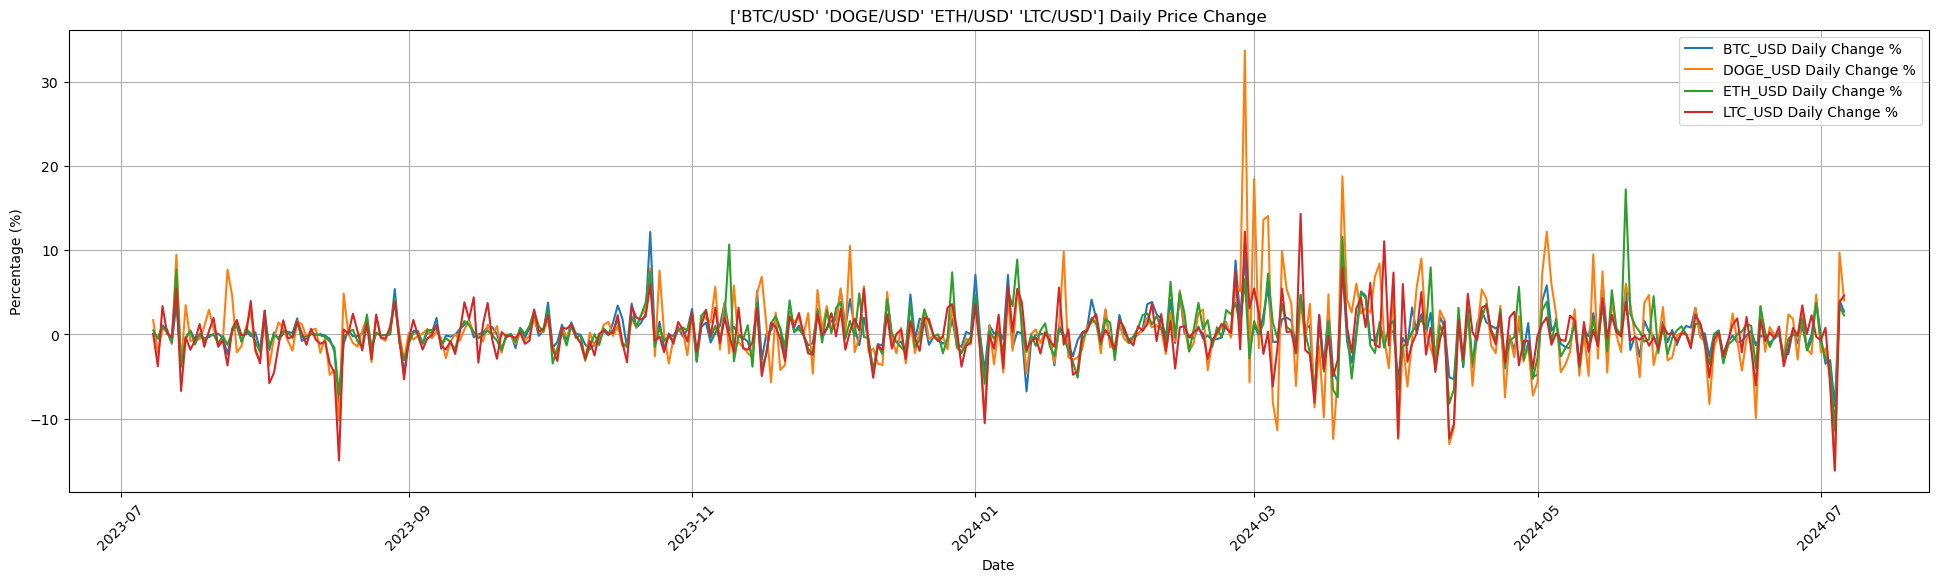

In [43]:
# Create a figure and axis for plotting
plt.figure(figsize=(24, 6))

for symbol in unique_symbols:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name

    plt.plot(locals()[f"crypto_df_{variable_name}"]['date'], 
             locals()[f"crypto_df_{variable_name}"]['daily change %'], 
             label=f'{variable_name} Daily Change %')
   
# Adding titles and labels
plt.title(f'{unique_symbols} Daily Price Change')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid()  # Show grid

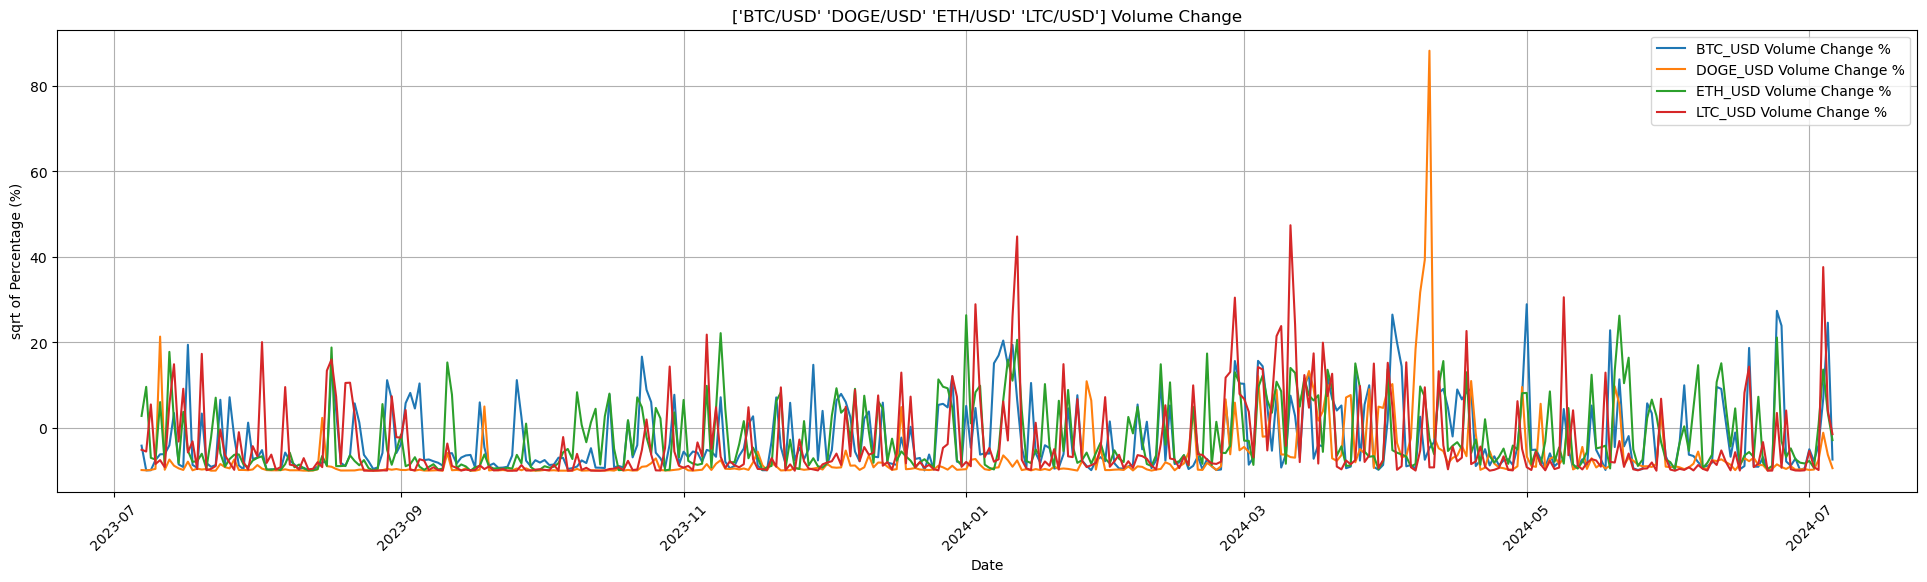

In [44]:
# Create a figure and axis for plotting
plt.figure(figsize=(24, 6))

for symbol in unique_symbols:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name

    plt.plot(locals()[f"crypto_df_{variable_name}"]['date'], 
             locals()[f"crypto_df_{variable_name}"]['vol_vs_average %'], 
             label=f'{variable_name} Volume Change %')
   
# Adding titles and labels
plt.title(f'{unique_symbols} Volume Change')
plt.xlabel('Date')
plt.ylabel('sqrt of Percentage (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid()  # Show grid

In [60]:
# user input for the ticker 
ticker_input = input("Enter the Stock symbols (e.g., NVDA, AMD, TSM, INTC): ")
ticker_list = [f"{ticker.strip()}" for ticker in ticker_input.split(",")]  # Format as f-string
# print(ticker_list)

Enter the Stock symbols (e.g., NVDA, AMD, TSM, INTC):  NVDA, AMD, TSM, INTC


In [61]:
def fetch_data(ticker_list, start_date, end_date, timeframe='1D'):
    all_data = []  # To hold DataFrames for all symbols
    
    for symbol in ticker_list:
        # Fetching bar data from Alpaca
        barset = api.get_bars(symbol, timeframe, start=start_date, end=end_date)
        
        # Convert the barset to a DataFrame
        bars_df = pd.DataFrame([{
            'ticker': symbol,
            'time': bar.t.strftime('%Y-%m-%d %H:%M:%S'),  # Converting timestamp to string
            'open': bar.o,
            'high': bar.h,
            'low': bar.l,
            'close': bar.c,
            'volume': bar.v
        } for bar in barset])

        # Append this symbol's DataFrame to the list
        all_data.append(bars_df)

    # Concatenate all individual DataFrames into one
    combined_df = pd.concat(all_data, ignore_index=True)

    return combined_df

# List of tickers
# print(ticker_list) 

# Fetching data and returning as a DataFrame
stock_df = fetch_data(ticker_list, start_date, end_date)

# Dynamically create DataFrames for each symbol
for symbol in ticker_list:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name
    stock_df.loc[:,'date'] = pd.to_datetime(stock_df.loc[:,'time']).dt.date
    clean_stock_df = stock_df.copy()[['ticker', 'date', 'open', 'close', 'volume']]
    globals()[f"{variable_name}_df"] = clean_stock_df[clean_stock_df['ticker'] == symbol]
#    print(f"\nDataFrame for {symbol}:\n", globals()[f"{variable_name}_df"])

In [47]:
for symbol in ticker_list:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name
    stock_df_calc = globals()[f"{variable_name}_df"].copy()  # Make sure to use .copy() to avoid SettingWithCopyWarning
              
    # Apply 1:10 split adjustment for NVDA before 2024-06-10
    if variable_name == 'NVDA':
        stock_df_calc['date'] = pd.to_datetime(stock_df_calc['date'])
        stock_df_calc.loc[stock_df_calc['date'] < pd.Timestamp('2024-06-10'), ['open', 'close']] /= 10
        stock_df_calc.loc[stock_df_calc['date'] < pd.Timestamp('2024-06-10'), ['volume']] *= 10
    
    # Run calculations
    stock_first_open = stock_df_calc['open'].iloc[0]
    stock_close = stock_df_calc['close']
    stock_open = stock_df_calc['open']
    price_change = ((stock_close - stock_first_open) / stock_first_open) * 100
    prev_close = stock_df_calc['close'].shift(1)
    daily_change = ((stock_close - prev_close) / prev_close) * 100
    weights = stock_df_calc['close']
    volume = stock_df_calc['volume']
    average_volume_stock = (volume * weights).sum() / weights.sum()
    volume_change = (((volume - average_volume_stock) / average_volume_stock) * 100)
    
    # to decrease the volume change range to manageable levels
    sqrt_volume_change = np.sqrt(np.abs(volume_change))

    # to retain the sign of the original volume change (positive or negative), you can reapply the sign
    sqrt_volume_change = np.sign(volume_change) * sqrt_volume_change

    # Use .loc[] to assign the new calculated columns
    stock_df_calc.loc[:,'price change %'] = price_change
    stock_df_calc.loc[:,'daily change %'] =  daily_change
    stock_df_calc.loc[:,'vol_vs_average %'] = sqrt_volume_change
    
    # Store the DataFrame with the new name
    locals()[f"stock_df_{variable_name}"] = stock_df_calc
    
    # Print out the DataFrame
#    print(f"\nDataFrame for {variable_name}:\n", locals()[f"stock_df_{variable_name}"])

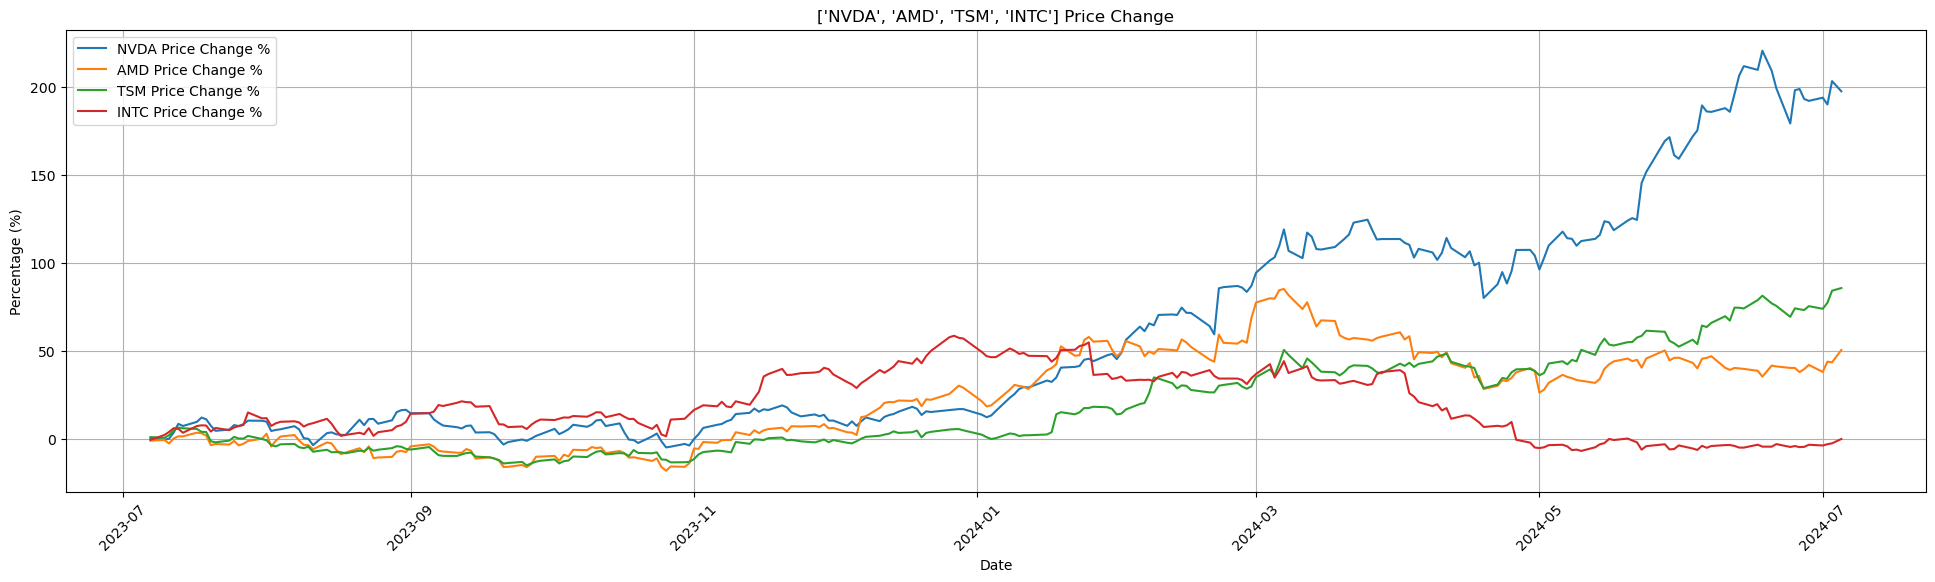

In [48]:
# Create a figure and axis for plotting
plt.figure(figsize=(24, 6))

for symbol in ticker_list:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name

    plt.plot(locals()[f"stock_df_{variable_name}"]['date'], 
             locals()[f"stock_df_{variable_name}"]['price change %'], 
             label=f'{variable_name} Price Change %')
   
# Adding titles and labels
plt.title(f'{ticker_list} Price Change')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid()  # Show grid

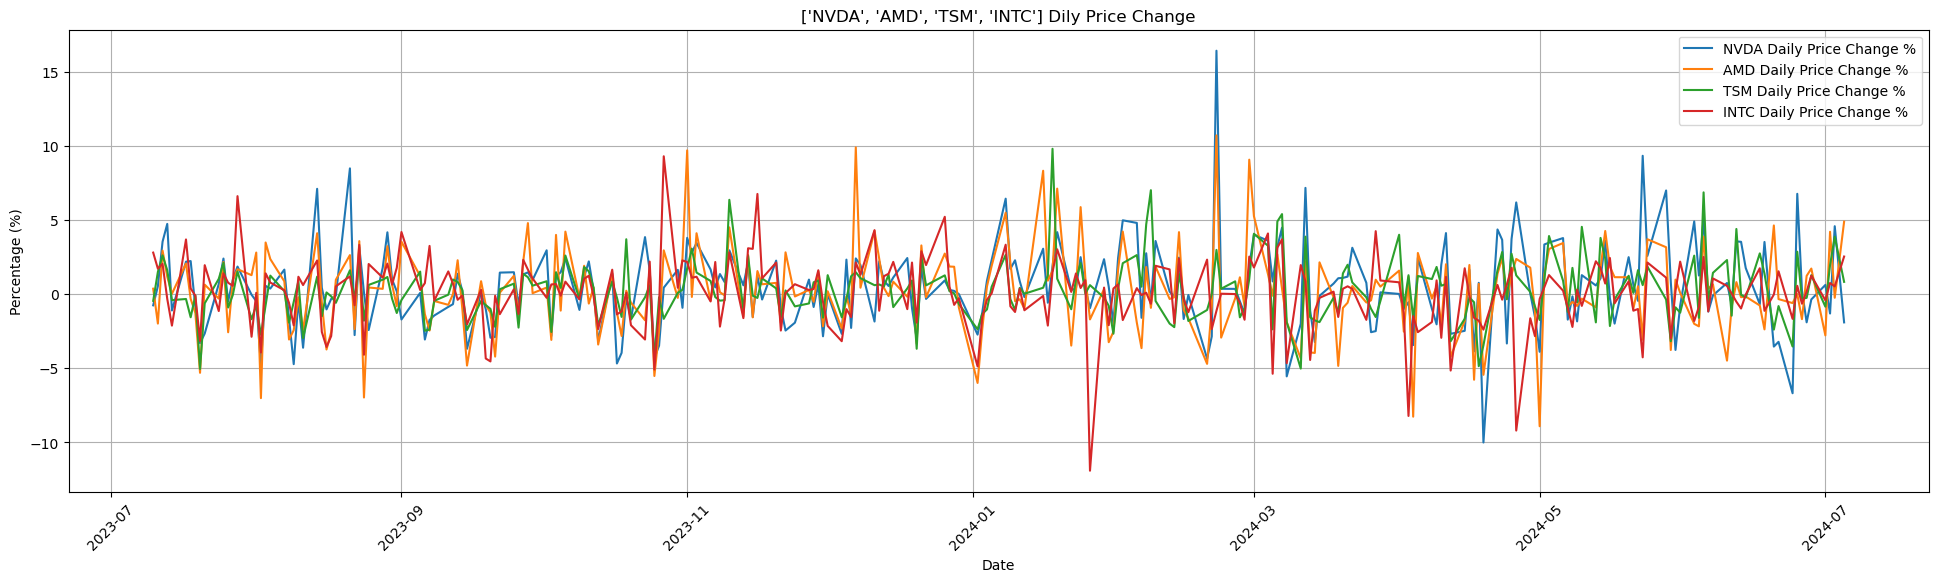

In [49]:
# Create a figure and axis for plotting
plt.figure(figsize=(24, 6))

for symbol in ticker_list:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name

    plt.plot(locals()[f"stock_df_{variable_name}"]['date'], 
             locals()[f"stock_df_{variable_name}"]['daily change %'], 
             label=f'{variable_name} Daily Price Change %')
   
# Adding titles and labels
plt.title(f'{ticker_list} Dily Price Change')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid()  # Show grid

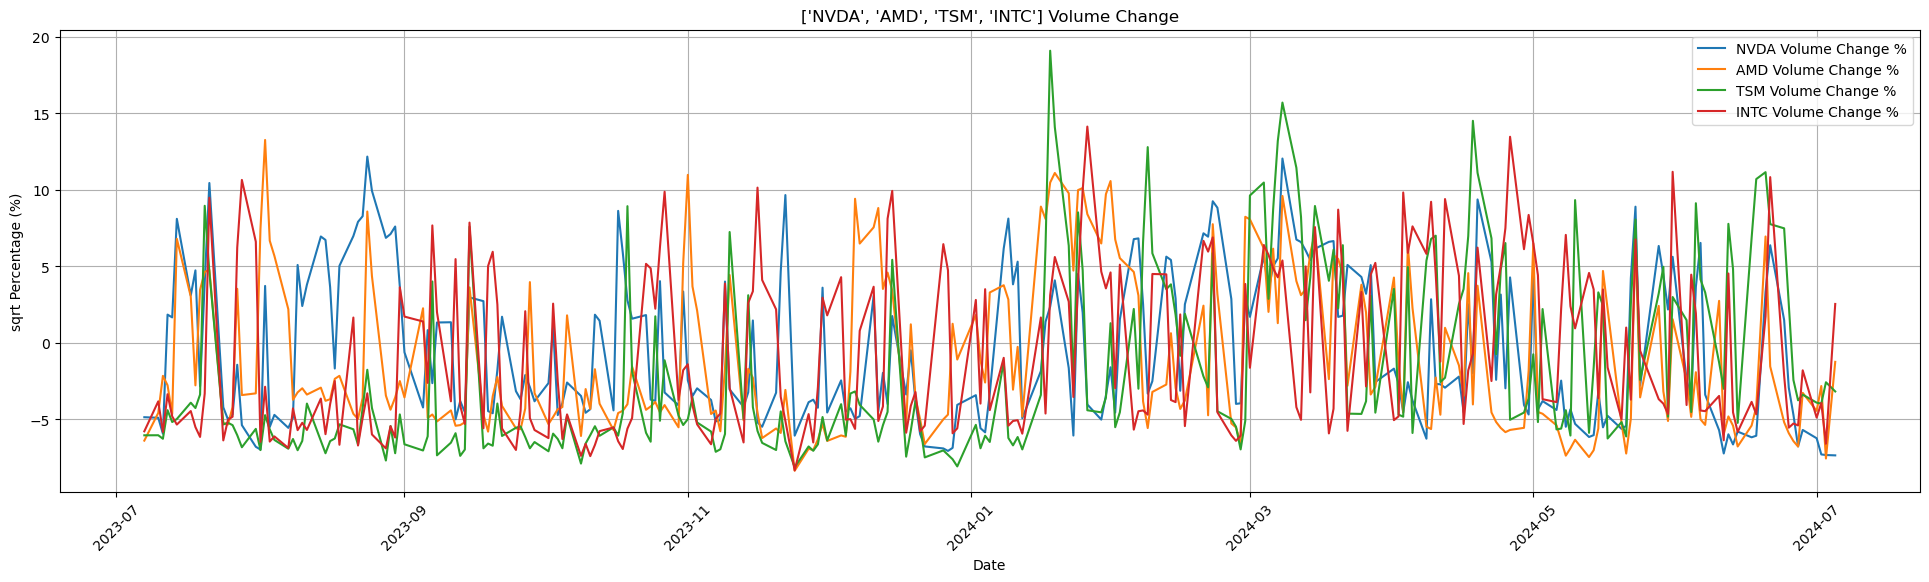

In [50]:
# Create a figure and axis for plotting
plt.figure(figsize=(24, 6))

for symbol in ticker_list:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name

    plt.plot(locals()[f"stock_df_{variable_name}"]['date'], 
             locals()[f"stock_df_{variable_name}"]['vol_vs_average %'], 
             label=f'{variable_name} Volume Change %')
   
# Adding titles and labels
plt.title(f'{ticker_list} Volume Change')
plt.xlabel('Date')
plt.ylabel('sqrt Percentage (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid()  # Show grid

In [59]:
# user input for the ticker 
ticker_index_input = input("Enter the Stock symbols (e.g., SPY, QQQ, EWU, EWJ): ")
ticker_index_list = [f"{ticker.strip()}" for ticker in ticker_index_input.split(",")]  # Format as f-string

Enter the Stock symbols (e.g., SPY, QQQ, EWU, EWJ):  SPY, QQQ, EWU, EWJ


In [58]:
def fetch_data(ticker_index_list, start_date, end_date, timeframe='1D'):
    all_data = []  # To hold DataFrames for all symbols
    
    for symbol in ticker_index_list:
        # Fetching bar data from Alpaca
        barset = api.get_bars(symbol, timeframe, start=start_date, end=end_date)
        
        # Convert the barset to a DataFrame
        bars_df = pd.DataFrame([{
            'ticker': symbol,
            'time': bar.t.strftime('%Y-%m-%d %H:%M:%S'),  # Converting timestamp to string
            'open': bar.o,
            'high': bar.h,
            'low': bar.l,
            'close': bar.c,
            'volume': bar.v
        } for bar in barset])

        # Append this symbol's DataFrame to the list
        all_data.append(bars_df)

    # Concatenate all individual DataFrames into one
    combined_df = pd.concat(all_data, ignore_index=True)

    return combined_df

# List of tickers
#print(ticker_index_list) 

# Fetching data and returning as a DataFrame
stock_index_df = fetch_data(ticker_index_list, start_date, end_date)

# Dynamically create DataFrames for each symbol
for symbol in ticker_index_list:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name
    stock_index_df.loc[:,'date'] = pd.to_datetime(stock_index_df.loc[:,'time']).dt.date
    clean_stock_index_df = stock_index_df.copy()[['ticker', 'date', 'open', 'close', 'volume']]
    globals()[f"{variable_name}_df"] = clean_stock_index_df[clean_stock_index_df['ticker'] == symbol]
#    print(f"\nDataFrame for {symbol}:\n", globals()[f"{variable_name}_df"])

In [53]:
for symbol in ticker_index_list:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name
    stock_index_df_calc = globals()[f"{variable_name}_df"].copy()  # Make sure to use .copy() to avoid SettingWithCopyWarning
              
    # Run calculations     
    stock_first_open = stock_index_df_calc['open'].iloc[0]
    stock_close = stock_index_df_calc['close']
    stock_open = stock_index_df_calc['open']
    price_change = ((stock_close - stock_first_open) / stock_first_open) * 100
    prev_close = stock_index_df_calc['close'].shift(1)
    daily_change = ((stock_close - prev_close) / prev_close) * 100
    weights = stock_index_df_calc['close']
    volume = stock_index_df_calc['volume']
    average_volume_stock = (volume * weights).sum() / weights.sum()
    volume_change = (((volume - average_volume_stock) / average_volume_stock) * 100)
    
    # to decrease the volume change range to manageable levels
    sqrt_volume_change = np.sqrt(np.abs(volume_change))

    # to retain the sign of the original volume change (positive or negative), you can reapply the sign
    sqrt_volume_change = np.sign(volume_change) * sqrt_volume_change

    # Use .loc[] to assign the new calculated columns
    stock_index_df_calc.loc[:,'price change %'] = price_change
    stock_index_df_calc.loc[:,'daily change %'] =  daily_change
    stock_index_df_calc.loc[:,'vol_vs_average %'] = sqrt_volume_change
    
    # Store the DataFrame with the new name
    locals()[f"stock_index_df_{variable_name}"] = stock_index_df_calc
    
    # Print out the DataFrame
#    print(f"\nDataFrame for {variable_name}:\n", locals()[f"stock_index_df_{variable_name}"])

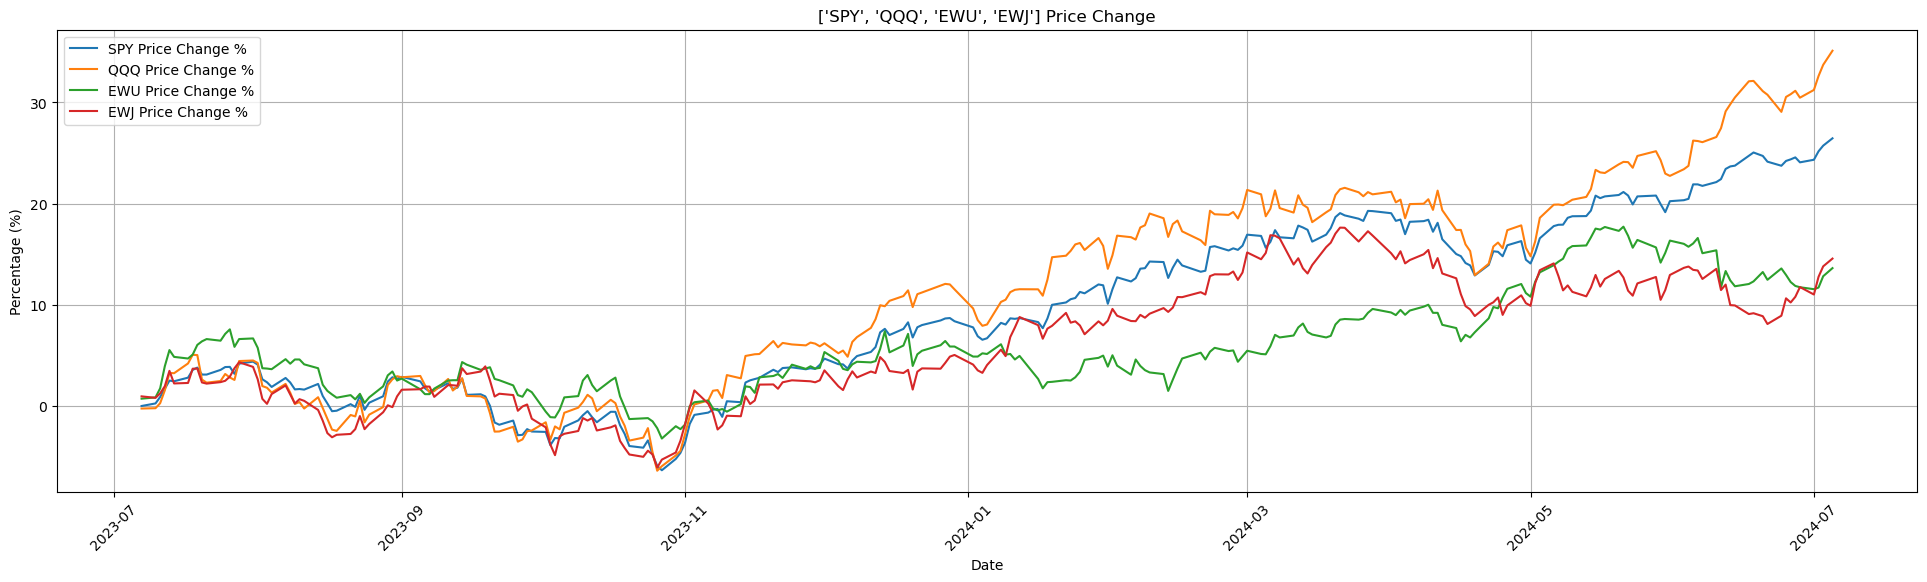

In [54]:
# Create a figure and axis for plotting
plt.figure(figsize=(24, 6))

for symbol in ticker_index_list:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name

    plt.plot(locals()[f"stock_index_df_{variable_name}"]['date'], 
             locals()[f"stock_index_df_{variable_name}"]['price change %'], 
             label=f'{variable_name} Price Change %')
   
# Adding titles and labels
plt.title(f'{ticker_index_list} Price Change')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid()  # Show grid

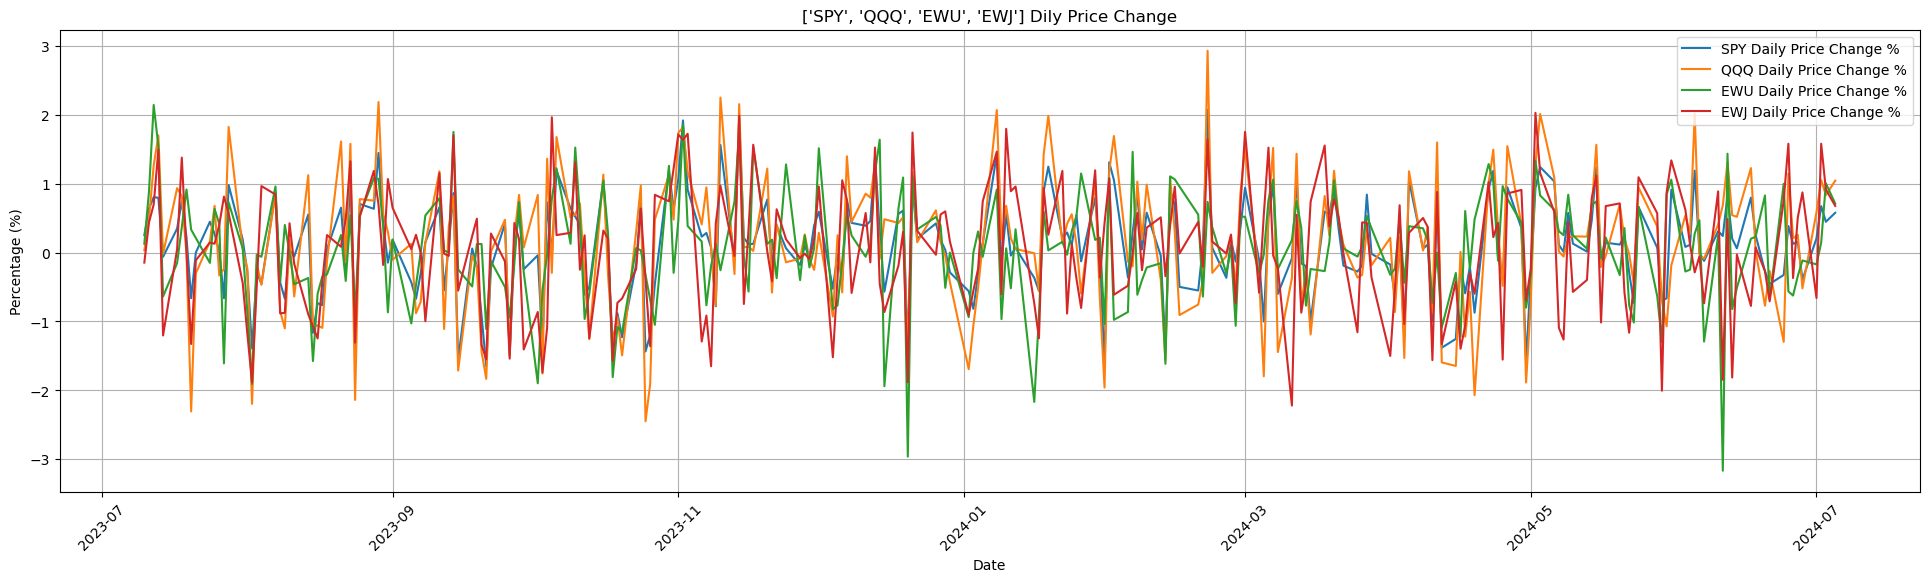

In [55]:
# Create a figure and axis for plotting
plt.figure(figsize=(24, 6))

for symbol in ticker_index_list:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name

    plt.plot(locals()[f"stock_index_df_{variable_name}"]['date'], 
             locals()[f"stock_index_df_{variable_name}"]['daily change %'], 
             label=f'{variable_name} Daily Price Change %')
   
# Adding titles and labels
plt.title(f'{ticker_index_list} Dily Price Change')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid()  # Show grid

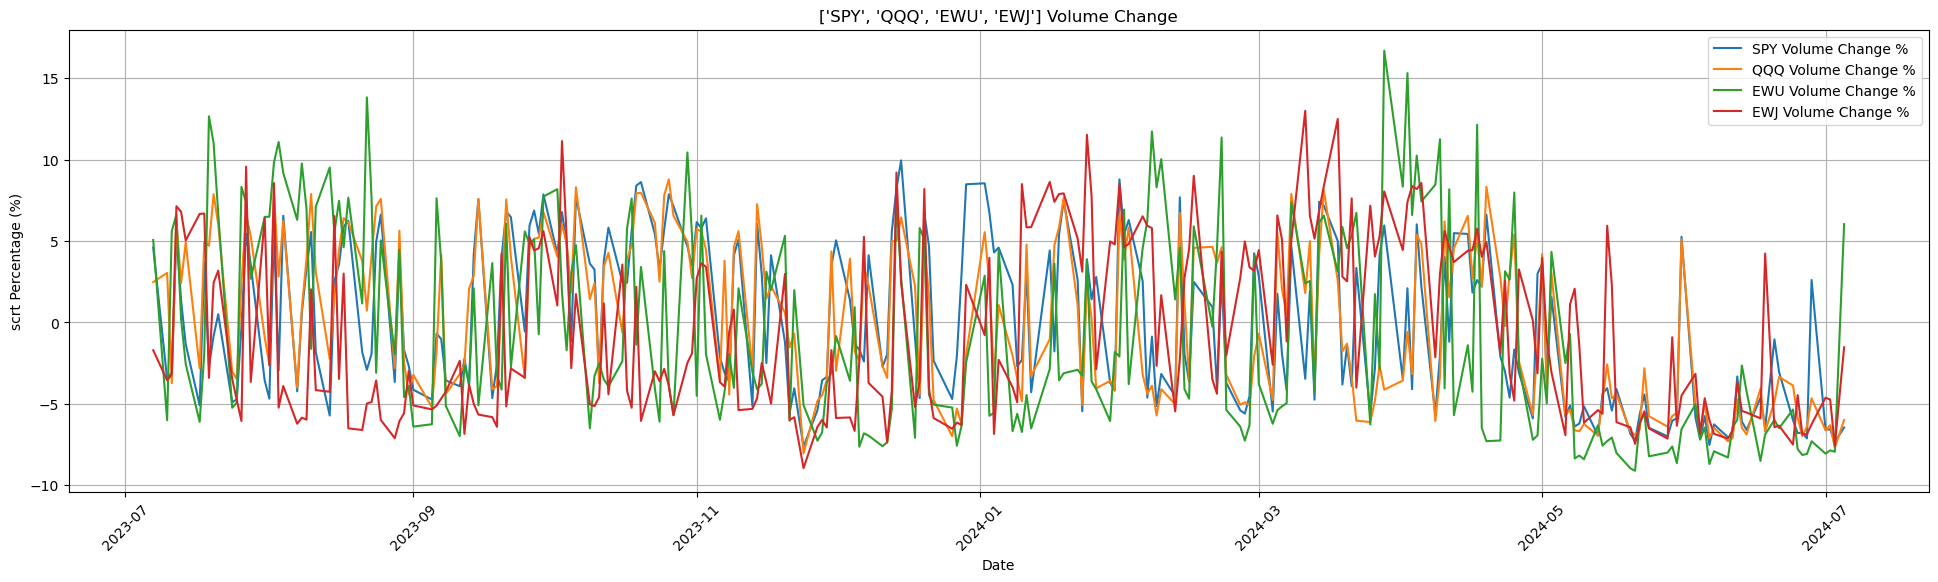

In [56]:
# Create a figure and axis for plotting
plt.figure(figsize=(24, 6))

for symbol in ticker_index_list:
    variable_name = symbol.replace('/', '_')  # Replace '/' with '_' to create a valid variable name

    plt.plot(locals()[f"stock_index_df_{variable_name}"]['date'], 
             locals()[f"stock_index_df_{variable_name}"]['vol_vs_average %'], 
             label=f'{variable_name} Volume Change %')
   
# Adding titles and labels
plt.title(f'{ticker_index_list} Volume Change')
plt.xlabel('Date')
plt.ylabel('scrt Percentage (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid()  # Show grid

Enter the cryptocurrency, stock, or index symbols (e.g., BTC/USD, NVDA, SPY or type 'exit' to quit):  DOGE/USD
Enter the graph you want: Price Change = P, Daily Price Change = D, Volume Change = V:  D


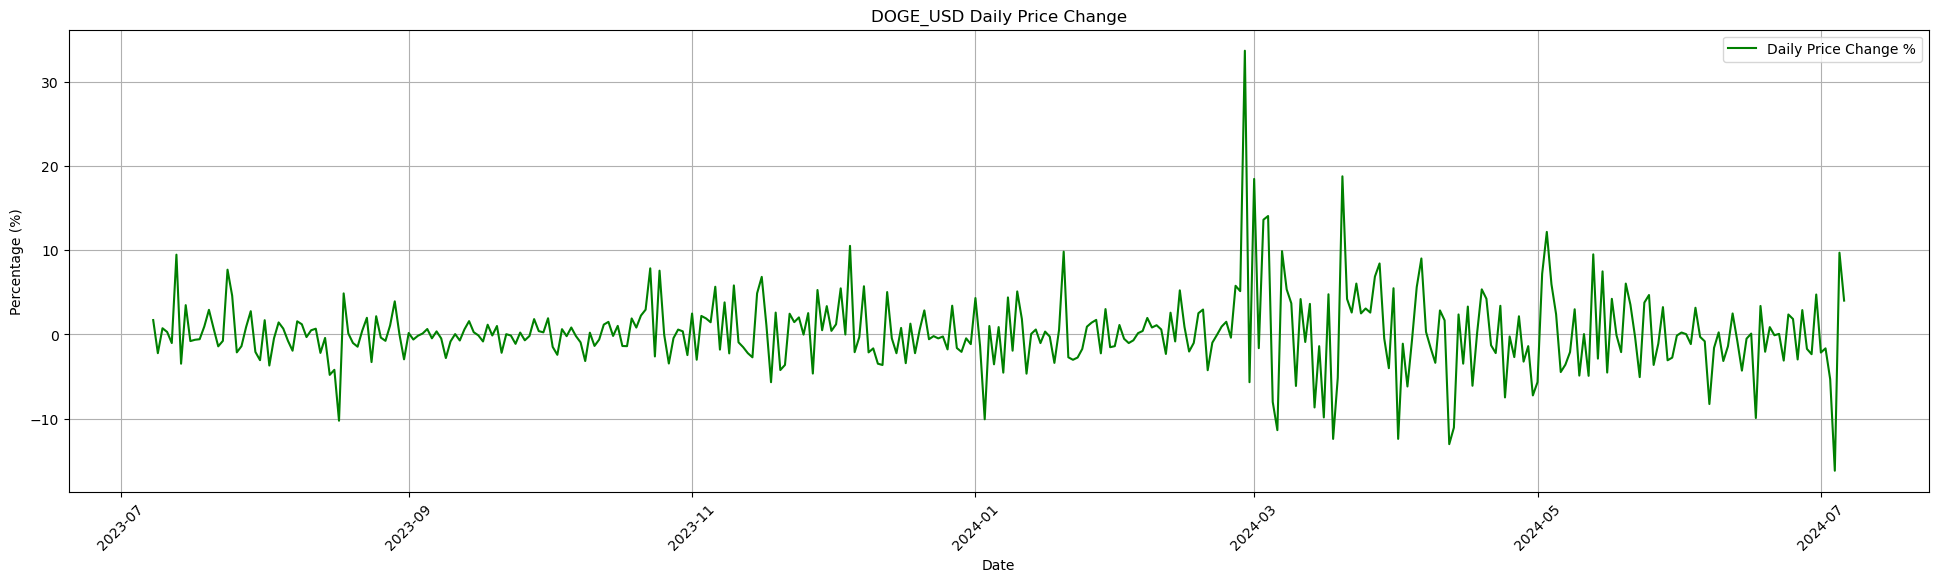

Enter the cryptocurrency, stock, or index symbols (e.g., BTC/USD, NVDA, SPY or type 'exit' to quit):  DOGE/USD
Enter the graph you want: Price Change = P, Daily Price Change = D, Volume Change = V:  V


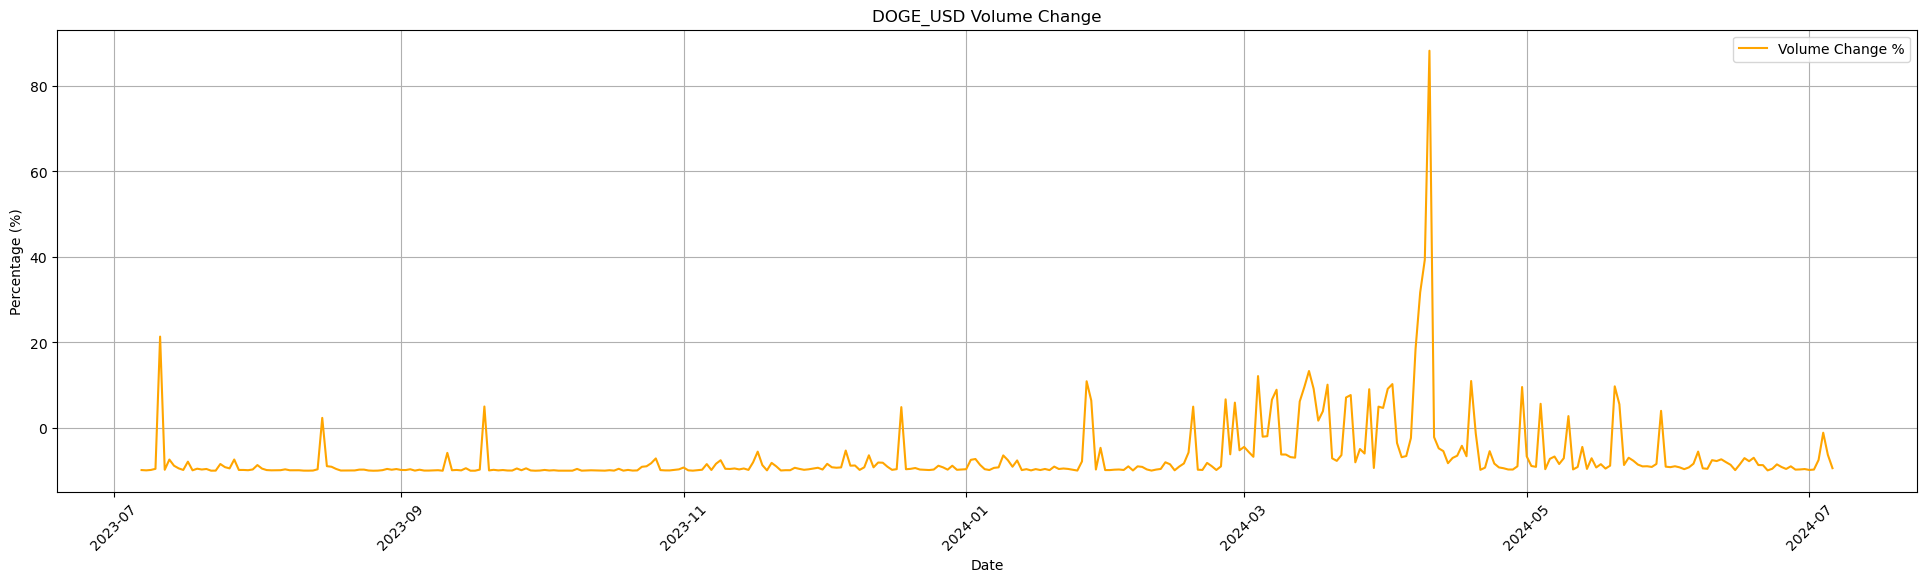

Enter the cryptocurrency, stock, or index symbols (e.g., BTC/USD, NVDA, SPY or type 'exit' to quit):  EXIT


Exiting the program.


In [57]:
# Create a custom plot
while True:
    try:
        # Get user input for the symbol and the type of plot
        custom_symbol = input("Enter the cryptocurrency, stock, or index symbols (e.g., BTC/USD, NVDA, SPY or type 'exit' to quit): ").upper()
        
        if custom_symbol == 'EXIT':
            print("Exiting the program.")
            break  # Exit the loop if the user types 'exit'
        
        custom_plot = input("Enter the graph you want: Price Change = P, Daily Price Change = D, Volume Change = V: ").upper()

        # Check if the symbol belongs to cryptocurrency, stock, or index list and assign the correct DataFrame
        if custom_symbol in unique_symbols:
            custom_symbol = custom_symbol.replace('/', '_')
            plot_df = locals()[f"crypto_df_{custom_symbol}"]
        elif custom_symbol in ticker_list:
            plot_df = locals()[f"stock_df_{custom_symbol}"]
        elif custom_symbol in ticker_index_list:
            plot_df = locals()[f"stock_index_df_{custom_symbol}"]
        else:
            print("Symbol not found")
            plot_df = None

        # Proceed only if a valid DataFrame is found
        if plot_df is not None:
            plt.figure(figsize=(24, 6))
            
            # Determine the type of graph based on the user's input
            if custom_plot == 'P':
                plt.plot(plot_df['date'], plot_df['price change %'], label='Price Change %', color='blue')
                plt.title(f'{custom_symbol} Price Change')
            elif custom_plot == 'D':
                plt.plot(plot_df['date'], plot_df['daily change %'], label='Daily Price Change %', color='green')
                plt.title(f'{custom_symbol} Daily Price Change')
            elif custom_plot == 'V':
                plt.plot(plot_df['date'], plot_df['vol_vs_average %'], label='Volume Change %', color='orange')
                plt.title(f'{custom_symbol} Volume Change')
            else:
                print("Invalid plot type selected")
                plt.close()
            
            # If a valid plot type was selected, display the graph
            if plt.get_fignums():
                plt.xlabel('Date')
                plt.ylabel('Percentage (%)')
                plt.xticks(rotation=45)
                plt.legend()
                plt.grid()
                plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

    # After each graph, ask the user if they want to input more or quit
    #continue_input = input("Do you want to plot another graph? (Y to continue, N to exit): ").lower()
    #if continue_input != 'Y':
        #print("Exiting the program.")
        #break
